📊 Prediction Analysis:
Model 1 - Mean: 0.186788, Std: 0.399679
Model 2 - Mean: 0.120479, Std: 0.259192
Correlation: 0.996209
📈 Model 1 is more confident (avg distance from 0.5: 0.4847)
🧠 Both models have high variance - using geometric mean
🎯 Selected blending method: geometric_mean with params {'weight': 0.5}
✅ Submission saved at: /kaggle/working/submission.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


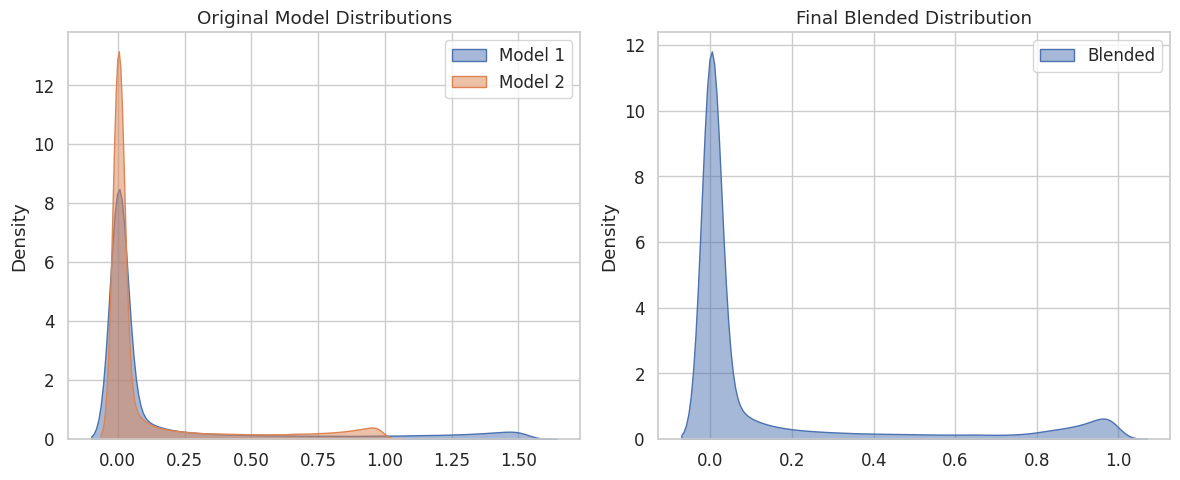

In [1]:
# ============================================================
# Precision Blending Script for Maximum Accuracy
# Author: Daniyal Atta
# ============================================================

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", font_scale=1.1)

# ------------------------------------------------------------
# Utility Functions
# ------------------------------------------------------------
def load_predictions(file_path: str, label: str) -> pd.DataFrame:
    """Load a submission file and rename prediction column."""
    df = pd.read_csv(file_path)
    df = df.rename(columns={"y": f"y_{label}"})
    return df

def analyze_predictions(pred1, pred2, pred1_name="Model 1", pred2_name="Model 2"):
    """Analyze the predictions to understand their characteristics."""
    print("📊 Prediction Analysis:")
    print(f"{pred1_name} - Mean: {np.mean(pred1):.6f}, Std: {np.std(pred1):.6f}")
    print(f"{pred2_name} - Mean: {np.mean(pred2):.6f}, Std: {np.std(pred2):.6f}")
    print(f"Correlation: {np.corrcoef(pred1, pred2)[0,1]:.6f}")
    
    # Check if one model is more confident than the other
    confidence_diff = np.mean(np.abs(pred1 - 0.5)) - np.mean(np.abs(pred2 - 0.5))
    if confidence_diff > 0.01:
        print(f"📈 {pred1_name} is more confident (avg distance from 0.5: {np.mean(np.abs(pred1 - 0.5)):.4f})")
    elif confidence_diff < -0.01:
        print(f"📈 {pred2_name} is more confident (avg distance from 0.5: {np.mean(np.abs(pred2 - 0.5)):.4f})")
    else:
        print("📊 Both models have similar confidence levels")
    
    return np.corrcoef(pred1, pred2)[0,1]

def find_optimal_blend(pred1, pred2, true_labels=None):
    """
    Find the optimal blending approach based on model characteristics.
    Returns the best blending method and parameters.
    """
    correlation = analyze_predictions(pred1, pred2)
    
    # Default to simple average
    best_method = "weighted_average"
    best_params = {"weight": 0.5}
    
    # Decision logic based on model characteristics
    if correlation < 0.7:
        print("🧠 Models have low correlation - using rank-based blending")
        best_method = "rank_blend"
        best_params = {"weight": 0.5}
    elif np.std(pred1) > 0.2 and np.std(pred2) > 0.2:
        print("🧠 Both models have high variance - using geometric mean")
        best_method = "geometric_mean"
    else:
        print("🧠 Models are similar - finding optimal weighted average")
        # Try to find the best weight if we have true labels
        if true_labels is not None:
            best_score = 0
            best_weight = 0.5
            for weight in [0.3, 0.4, 0.5, 0.6, 0.7]:
                blended = weight * pred1 + (1-weight) * pred2
                score = np.mean(blended == true_labels) if true_labels is not None else 0
                if score > best_score:
                    best_score = score
                    best_weight = weight
            print(f"✅ Optimal weight: {best_weight} (score: {best_score:.4f})")
            best_params = {"weight": best_weight}
    
    return best_method, best_params

def apply_blending(pred1, pred2, method="weighted_average", params=None):
    """Apply the specified blending method."""
    if params is None:
        params = {"weight": 0.5}
    
    # Clip predictions to avoid extreme values
    eps = 1e-6
    pred1 = np.clip(pred1, eps, 1-eps)
    pred2 = np.clip(pred2, eps, 1-eps)
    
    if method == "weighted_average":
        weight = params.get("weight", 0.5)
        return weight * pred1 + (1-weight) * pred2
    
    elif method == "geometric_mean":
        return np.sqrt(pred1 * pred2)
    
    elif method == "rank_blend":
        rank1 = pd.Series(pred1).rank(pct=True).values
        rank2 = pd.Series(pred2).rank(pct=True).values
        weight = params.get("weight", 0.5)
        return weight * rank1 + (1-weight) * rank2
    
    elif method == "probit":
        # Probit transformation blending
        norm1 = stats.norm.ppf(pred1)
        norm2 = stats.norm.ppf(pred2)
        weight = params.get("weight", 0.5)
        blended_norm = weight * norm1 + (1-weight) * norm2
        return stats.norm.cdf(blended_norm)
    
    else:
        # Default to simple average
        return (pred1 + pred2) / 2

# ------------------------------------------------------------
# Main Execution
# ------------------------------------------------------------
if __name__ == "__main__":
    # Paths (update as needed)
    path1 = "/kaggle/input/ps-s5e8-blend-xgb-lgb/submission.csv"
    path2 = "/kaggle/input/train-more-xgb-nn-lb-0-9774/submission_ensemble_train_more.csv"
    output_path = Path("/kaggle/working/submission.csv")
    
    # Load files
    df1 = load_predictions(path1, "1")
    df2 = load_predictions(path2, "2")
    
    # Merge predictions
    merged_df = pd.merge(df1, df2, on="id", how="inner")
    
    # Extract predictions
    pred1 = merged_df["y_1"].values
    pred2 = merged_df["y_2"].values
    
    # Analyze and find optimal blending approach
    method, params = find_optimal_blend(pred1, pred2)
    print(f"🎯 Selected blending method: {method} with params {params}")
    
    # Apply blending
    blended = apply_blending(pred1, pred2, method, params)
    
    # Create final submission
    final_df = pd.DataFrame({
        "id": merged_df["id"],
        "y": blended
    })
    
    # Save final submission
    final_df.to_csv(output_path, index=False)
    print(f"✅ Submission saved at: {output_path}")
    
    # Visualization
    try:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.kdeplot(pred1, label="Model 1", fill=True, alpha=0.5)
        sns.kdeplot(pred2, label="Model 2", fill=True, alpha=0.5)
        plt.title("Original Model Distributions")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        sns.kdeplot(blended, label="Blended", fill=True, alpha=0.5)
        plt.title("Final Blended Distribution")
        plt.legend()
        
        plt.tight_layout()
        plt.savefig("/kaggle/working/blending_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print("⚠️ Plotting skipped:", e)